# Исследование Heavy Metal групп на предмет закономерностей

## Материалы

<a href="https://drive.google.com/file/d/1dDXezGgFcJNCcX_xQHhcAlYB48YQDuaQ/view?usp=sharing">Ссылка на презентацию</a>

## Практическая часть

### 1. Предобработка

In [1]:
import pandas as pd
import numpy as np
import re
import plotly.express as px

Полученные при помощи парсинга данные оказались несколько сырыми и их требовалось обработать. 

Основные проблемы:
   1. Типы данных
   2. Названия столбцов
   3. Неудобное для исследования нагромождение жанров

In [2]:
df = pd.read_csv('bands_dataset.csv',sep=',',header=0,index_col=None)
df = df.drop('Unnamed: 0',axis=1)
df.head()

,Band,Style,Country,Formed,Split,Fans
0,Iron Maiden,New wave of British heavy Heavy,United Kingdom,1975,-,5130
1,Opeth,Extreme progressive ProgressiveProgressive rock,Sweden,1990,-,4861
2,Metallica,HeavyBay Area thrash,USA,1981,-,4385
3,Megadeth,Thrash Heavy Hard rock,USA,1983,-,3663
4,Slayer,Thrash,USA,1981,2019,3461


In [3]:
df.columns = ['band','style','country','formed','split','metalstorm_fans']

In [4]:
df.dtypes

band               object
style              object
country            object
formed             object
split              object
metalstorm_fans     int64
dtype: object

In [5]:
df['formed'] = df['formed'].replace('-',0).fillna(0).astype('int64')
df['split'] = df['split'].replace('-',0).fillna(0).astype('int64')

In [6]:
def style_sep(x):
    return ','.join([i.strip().lower() for i in re.findall('[a-zA-Z][^A-Z]*', x)])

In [7]:
df['style'] = df['style'].str.replace('British','british')\
.str.replace('Area','area')

In [8]:
df['style'] = df['style'].apply(style_sep)

In [9]:
df.head()

,band,style,country,formed,split,metalstorm_fans
0,Iron Maiden,"new wave of british heavy,heavy",United Kingdom,1975,0,5130
1,Opeth,"extreme progressive,progressive,progressive rock",Sweden,1990,0,4861
2,Metallica,"heavy,bay area thrash",USA,1981,0,4385
3,Megadeth,"thrash,heavy,hard rock",USA,1983,0,3663
4,Slayer,thrash,USA,1981,2019,3461


Кроме того, потребовалось заменить часть неудобных названий жанров, которые не попадали под изначальную задумку деления:

In [10]:
df['style'] = df['style'].str.replace('metal','')\
.str.replace("death 'n' roll","death-'n'-roll")\
.str.replace("rock 'n' roll","rock-'n'-roll")\
.str.replace("synth wave","synth-wave")\
.str.replace("dungeon synth","dungeon-synth")

### 2. Разбор групп по жанрам

После этого можно было, согласно изначальной предпосылке, разделить полные жанры всех групп на основные жанры и их модификаторы:

In [11]:
def main_style_revision(x):
    line = x.split(',')
    if pd.Series([len(i.split()) for i in line]).all() > 0:
        return ','.join(set([i.split()[-1] for i in line]))
    return 0 

                    
def style_modifier_revision(x):
    line = x.split(',')
    box = []
    for i in line:
        if len(i.split()[:-1]) != 0:
            box.append(' '.join(i.split()[:-1]))
    return ','.join(set(box))

In [12]:
df['main_style'] = df['style'].apply(main_style_revision)
df['style_modifier'] = df['style'].apply(style_modifier_revision).replace('',0)

In [13]:
df.head()

,band,style,country,formed,split,metalstorm_fans,main_style,style_modifier
0,Iron Maiden,"new wave of british heavy,heavy",United Kingdom,1975,0,5130,heavy,new wave of british
1,Opeth,"extreme progressive,progressive,progressive rock",Sweden,1990,0,4861,"progressive,rock","progressive,extreme"
2,Metallica,"heavy,bay area thrash",USA,1981,0,4385,"thrash,heavy",bay area
3,Megadeth,"thrash,heavy,hard rock",USA,1983,0,3663,"thrash,rock,heavy",hard
4,Slayer,thrash,USA,1981,2019,3461,thrash,0


In [14]:
def style_agg(x,box):
    if x != 0:
        line = x.split(',')
        for i in line:
            if i not in box.keys():
                box[i] = 0
            box[i] += 1

In [15]:
main_style_libr = {}
style_modifier_libr = {}
complete_style_libr = {}

In [16]:
df['main_style'].apply(style_agg,box=main_style_libr)
df['style_modifier'].apply(style_agg,box=style_modifier_libr)
df['style'].apply(style_agg,box=complete_style_libr)
print(f"Основных жанров: {len(main_style_libr)}")
print(f"Модификаторов: {len(style_modifier_libr)}")
print(f"Полных жанров: {len(complete_style_libr)}")

Основных жанров: 106
Модификаторов: 79
Полных жанров: 329


In [17]:
def to_dataframe(libr,c1):
    df = pd.DataFrame({
    c1 : libr.keys(),
    'count' : libr.values()}).sort_values(by='count',ascending=False).reset_index(drop=True)
    df['part'] = np.around(df['count'] / df['count'].sum()*100,2)
    return df

In [18]:
main_style_libr = to_dataframe(main_style_libr,'style')
style_modifier_libr = to_dataframe(style_modifier_libr,'style')
complete_style_libr = to_dataframe(complete_style_libr,'style')

In [19]:
def visual_1(x,y,text,color,title,tx,ty):
    fig = px.bar(x=x,y=y,text=text,color_discrete_sequence=color)
    fig.update_layout(width=900,height=550,title=title,xaxis_title=tx,yaxis_title=ty,
                      template='plotly_dark',font=dict(size=15),xaxis=dict(showgrid=False),yaxis=dict(showgrid=False))
    fig.show("png")

**Результат агрегации по жанрам:**

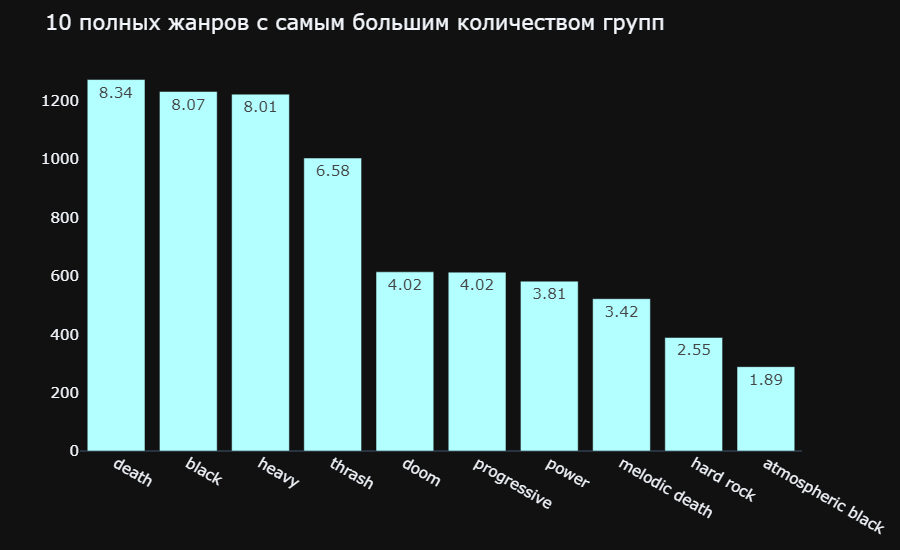

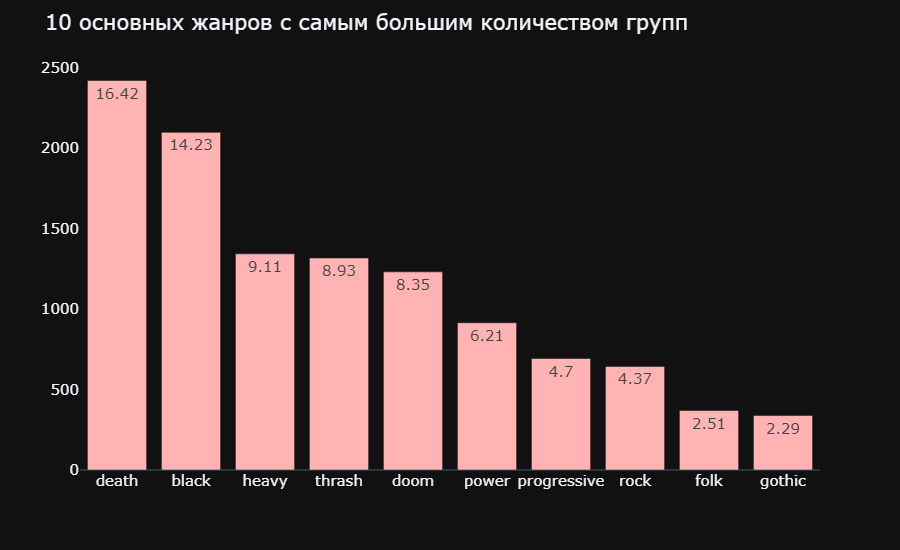

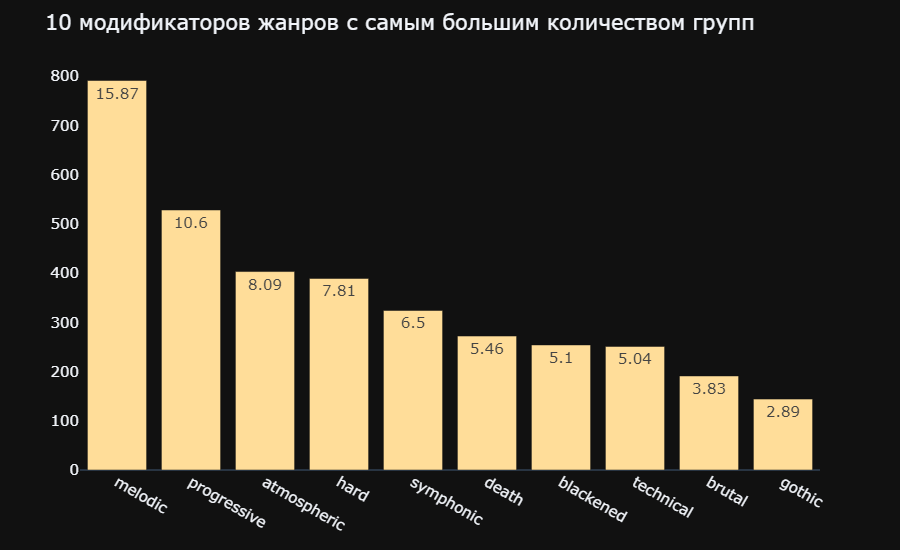

In [20]:
visual_1(complete_style_libr['style'].head(10),
         complete_style_libr['count'].head(10),
         complete_style_libr['part'].head(10),
         ['#b3ffff'],
         '10 полных жанров с самым большим количеством групп',
        None,None)
visual_1(main_style_libr['style'].head(10),
         main_style_libr['count'].head(10),
         main_style_libr['part'].head(10),
         ['#ffb3b3'],
         '10 основных жанров с самым большим количеством групп',
        None,None)
visual_1(style_modifier_libr['style'].head(10),
         style_modifier_libr['count'].head(10),
         style_modifier_libr['part'].head(10),
         ['#ffdd99'],
         '10 модификаторов жанров с самым большим количеством групп',
        None,None)

**Вывод:** полные и основные жанры очень близки друг к другу в верхних слоях таблицы. Наиболее популярными здесь являются Death, Black, Heavy, Thrash и Doom. Наиболее распространенными модификаторами для них являются Melodic, Progressive, Atmospheric, Hard и Symphonic. Самыми распространенными полными жанрами, включающими модификаторы, являются Melodic Death, Hard Rock и Atmospheric Black. 

### 3. Разбор групп по годам

Далее интересно было рассмотреть динамику появления новых групп по годам.

In [21]:
def visual_2(x,y,color,title,tx,ty):
    fig = px.area(x=x,y=y,color_discrete_sequence=color)
    fig.update_layout(width=900,height=550,title=title,xaxis_title=tx,yaxis_title=ty,
                      template='plotly_dark',font=dict(size=15),xaxis=dict(showgrid=False),yaxis=dict(showgrid=False))
    fig.show("png")

In [22]:
year_distribution = df.query('formed != 0').groupby('formed',as_index=False).agg({'band':'nunique'}).\
rename(columns={'band':'count'})

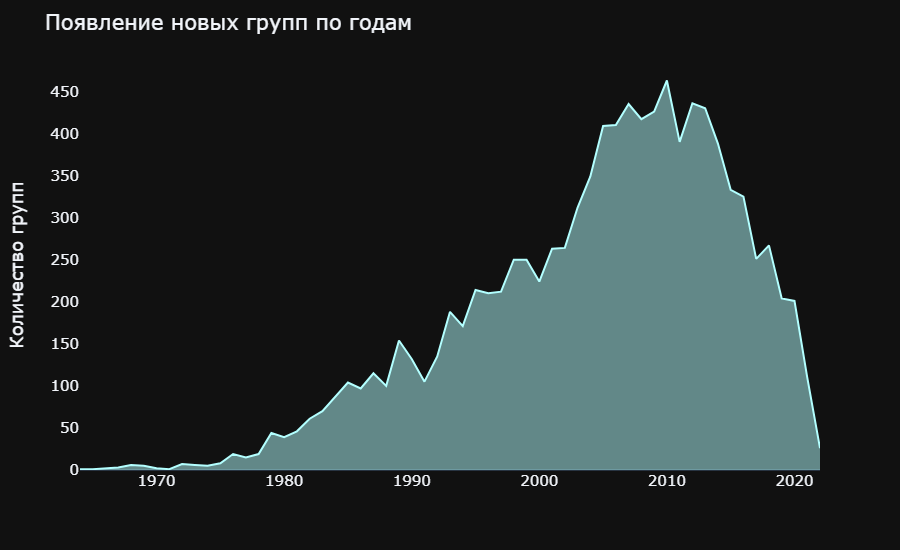

In [23]:
visual_2(year_distribution['formed'],
         year_distribution['count'],
         ['#b3ffff'],
         'Появление новых групп по годам',
         None,'Количество групп')

**Вывод:** как выяснилось, зарождение жанра началось в конце 70-ых - начале 80-ых, бурный подъем пришелся на 90-ые и нулевые, а пик - на десятые. После этого начался серьезный спад, из-за которого сейчас новых групп появляется крайне мало.

### 4. Разбор групп по странам

Другим интересным вопросом было то, какие страны наиболее обильно поставляют контент на металическую сецену.

Однако сперва нужно было обработать таблицу, чтобы правильно распределить по странам значения групп, в которых присутствуюет многонациональный состав.

In [24]:
country_distribution = df.groupby('country',as_index=False).agg({'band':'nunique'}).sort_values(by='band',ascending=False).\
rename(columns={'band':'count'})

In [25]:
def county_redistribution(row,df):
    country_line = row['country'].split(', ')
    for i in country_line:
        df.loc[df[df.loc[:,'country']==i].index,'count'] += row['count']

In [26]:
dbl_ctr = country_distribution[country_distribution['country'].str.contains(',', regex=False)]

In [27]:
dbl_ctr.apply(county_redistribution,axis=1,df=country_distribution)
country_distribution = country_distribution[~country_distribution['country'].isin(dbl_ctr['country'])].copy().\
reset_index(drop=True)

In [28]:
country_distribution['part'] = np.around(country_distribution['count'] / country_distribution['count'].sum()*100,2)

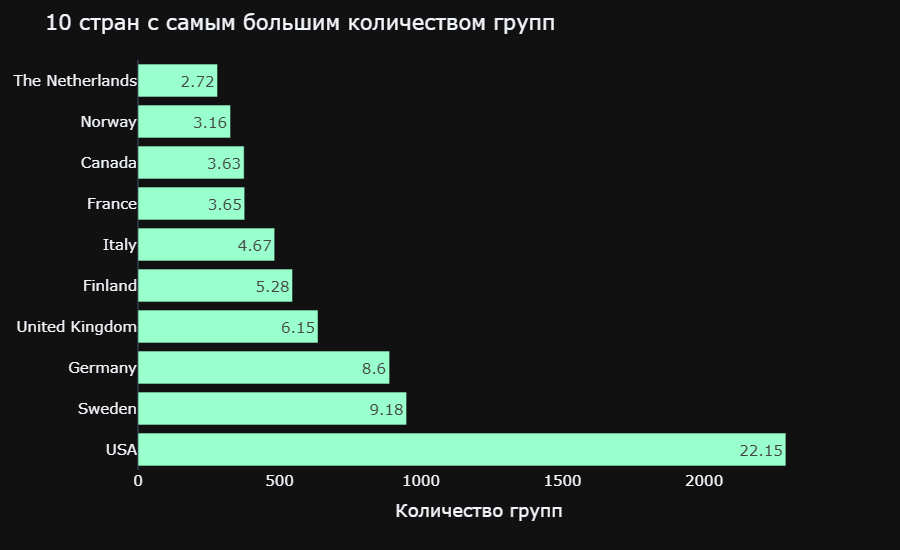

In [29]:
visual_1(country_distribution['count'].head(10),
         country_distribution['country'].head(10),
         country_distribution['part'].head(10),
         ['#99ffcc'],
         '10 стран с самым большим количеством групп',
        'Количество групп',None)

**Вывод:** закономерно, первое место с большим отрывом здесь занимает США с более чем 20% от всех групп. Далее следуют Германия и Швеция, а за ними - Англия и Финлядния. Также в топ-10 попали Иналия, Франция, Канада, Норвегия и Нидерланды. Результат оказался несколько неожиданным, поскольку до начала исследования было трудно даже предположить, что в Италии и Франции групп окажется больше, чем в известной своей сценой Норвегии.

### 5. Разбор названий по словам

В качестве эксперимента, любопытно было узнать, какие слова группы чаще всего включают в свои названия.

Чтобы результат был более содержательным, из списка были удалены стоп-слова английского языка, то есть наиболее часто встречающиеся служебные элементы.

In [30]:
word_libr = {}
def word_counter(x,libr):
    line = x.split()
    for i in line:
        if i not in libr:
            libr[i] = 0
        libr[i] += 1

In [31]:
df['band'].apply(word_counter,libr=word_libr)
word_libr = to_dataframe(word_libr,'word')

In [32]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [33]:
word_libr = word_libr.query('word.str.lower() not in @stop_words').copy().reset_index(drop=True)

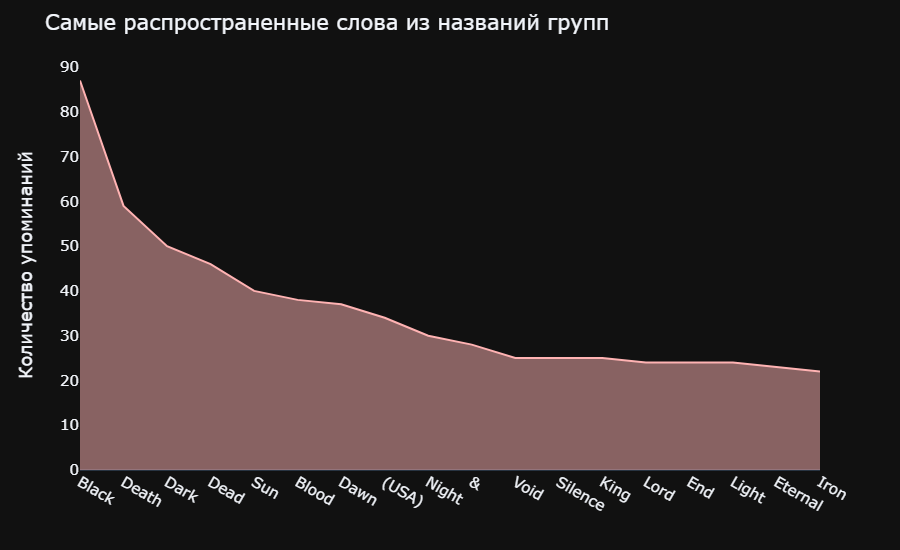

In [34]:
visual_2(word_libr['word'].head(18),
         word_libr['count'].head(18),
         ['#ffb3b3'],
         'Самые распространенные слова из названий групп',
         None,'Количество упоминаний')

**Вывод:** слово Black, по какой-то причине, особенно импонирует металистам, так же как слова Death, Dead  и Dark. Однако есть в топе и противоположные по атмосфере слова: Sun, Dawn, Light. Видимо сказывается любовь музыкантов к противопоставлениям.

### 6. Разбор фанатов по жанрам

Кроме непосредственного распределения числа групп по жанрам хотелось рассмотреть колебание количества слушателей. 

Для рассмотрения были взяты 10 самых популярных основных жанров, уже выведенных ранее.

In [35]:
def fan_counter(x,df_out):
    bands = df_out.query('@x in main_style')
    return bands['metalstorm_fans'].sum()

In [36]:
main_style_libr['fans'] = main_style_libr['style'].apply(fan_counter,df_out=df)

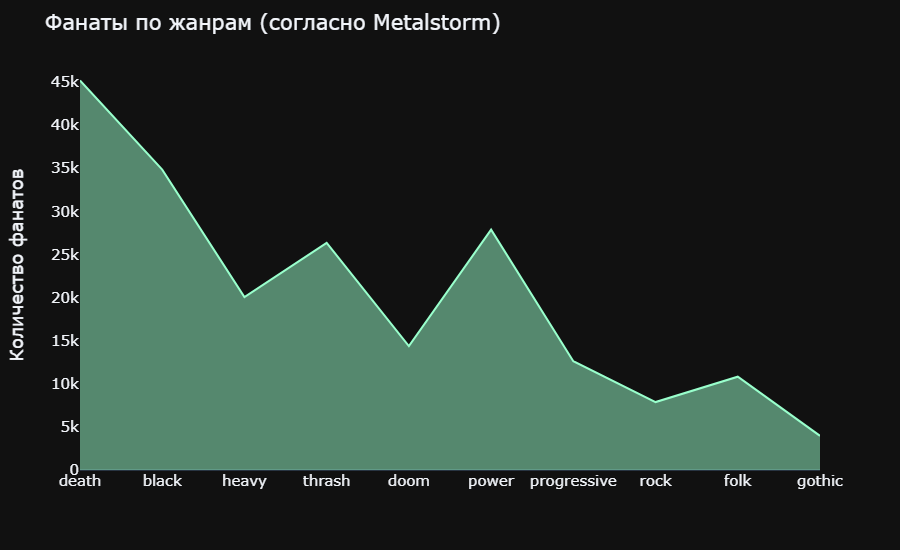

In [37]:
visual_2(main_style_libr['style'].head(10),
         main_style_libr['fans'].head(10),
         ['#99ffcc'],
         'Фанаты по жанрам (согласно Metalstorm)',
         None,'Количество фанатов')

**Вывод:** Death и Balck держат планку с самым высоким количеством фанатов, однако Heavy, Thrash и Doom уступают по количеству фанатов жанру Power. Это говорит о том, что хотя в этом жанре выступает меньше коллективов, их фан-база более обширная и более сплоченная.

### 7. Разбор жанров по странам

Последний этап исследования - синтез нескольких предыдущих. Здесь для каждой из 5 стран с наибольшим количеством групп требуется узнать, какие полные жанры в них превалируют.

In [38]:
country_style = pd.DataFrame({
    'country' : [],
    'style' : [],
    'count' : []})

In [39]:
def style_sep(y,libr):
    if y != 0:
        box = y.split(',')
        for i in box:
            if i not in libr.keys():
                libr[i] = 0
            libr[i] += 1
        
def country_style_distr(x,col,df_out):
    global country_style
    bands = df_out.query('country == @x')
    libr = {}
    bands[col].apply(style_sep,libr=libr)
    dt = pd.DataFrame({
        'country' : [x for i in range(len(libr))],
        'style' : libr.keys(),
        'count' : libr.values()})
    country_style = pd.concat([country_style,dt]) 

In [40]:
country_distribution['country'].apply(country_style_distr,col='style',df_out=df)
print(len(country_style))

2832


In [41]:
country_style = country_style.sort_values(by=['country','count'],ascending=False).reset_index(drop=True)

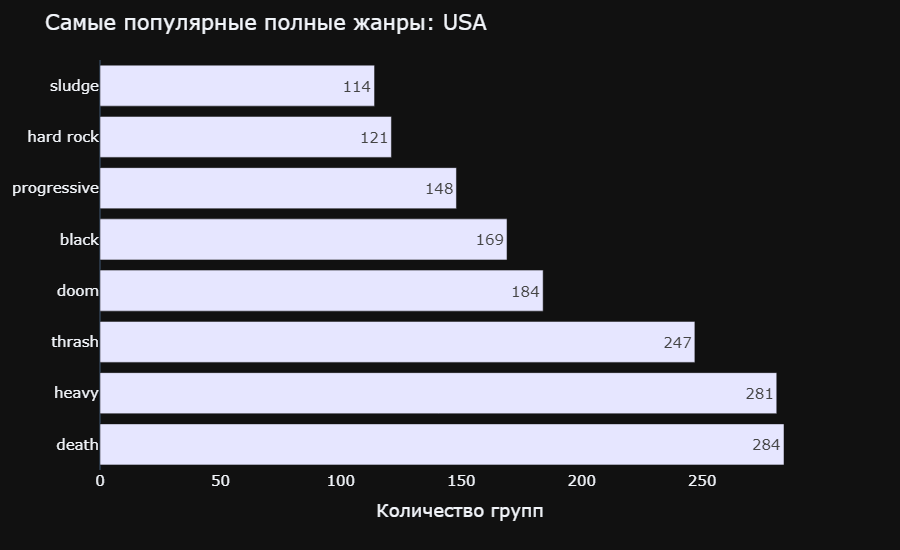

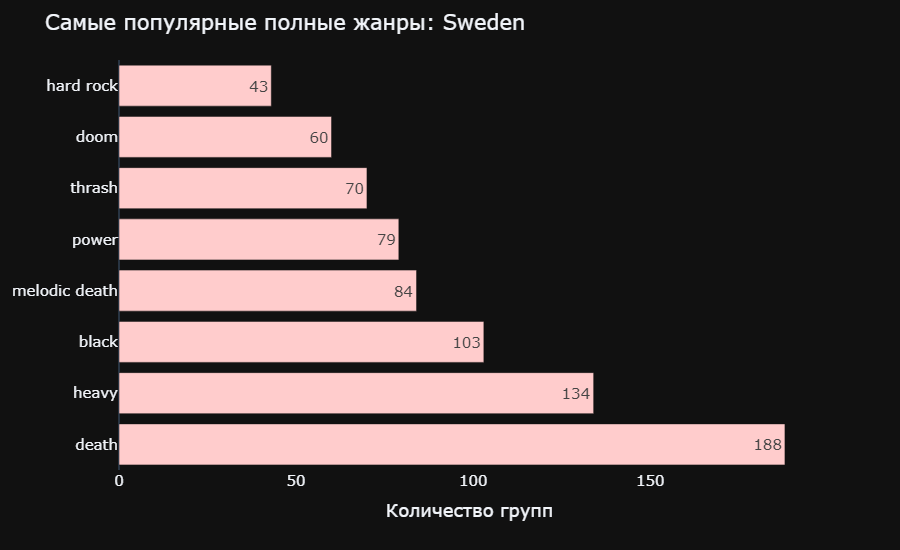

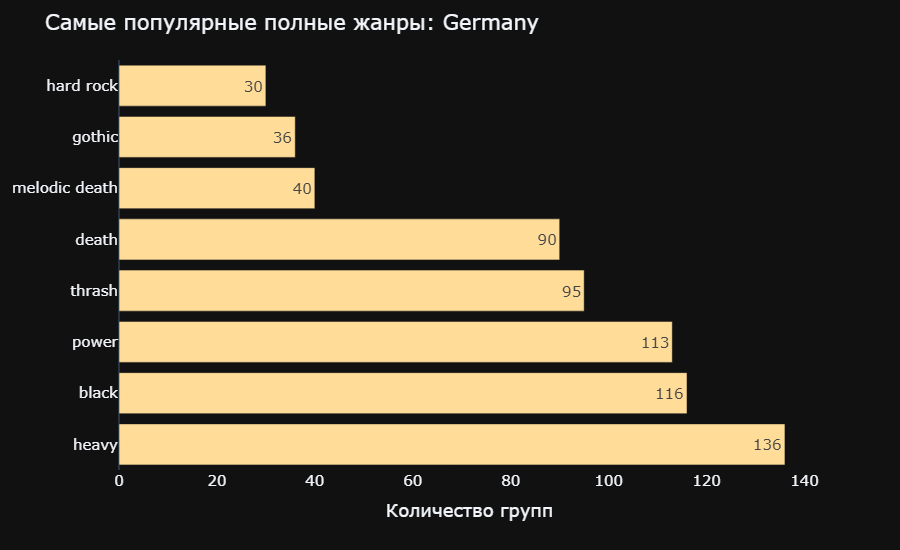

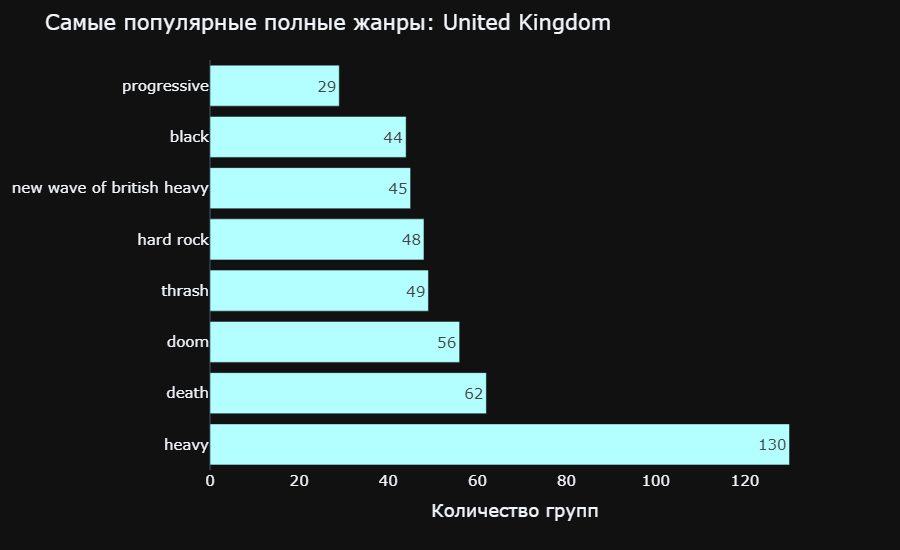

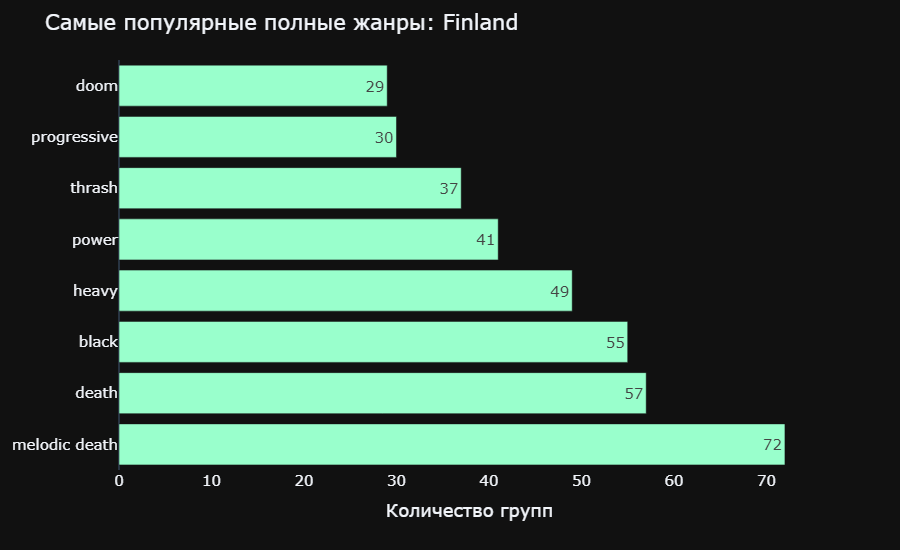

In [42]:
palette = [['#e6e6ff'],['#ffcccc'],['#ffdd99'],['#b3ffff'],['#99ffcc']]
n = 0
for c in country_distribution.head()['country']:
    style_box = country_style.query('country == @c').head(8)
    visual_1(style_box['count'].head(8),
         style_box['style'].head(8),
         style_box['count'].head(8),
         palette[n],
         f'Самые популярные полные жанры: {c}',
        'Количество групп',None)
    n += 1

**Вывод:** в целом, картина жанров по странам отражает общую, выведенную ранее тенденцию, однако с определенной национальной спецификой. Так, США, Швеция и Англия сохраняют жесткую приверженность к классическим Death и Heavy, в Германии много групп играет Black и Power, а фины отдаю предпочтение Melodic Death. При дальнейшем рассмотрении точно можно было бы установить зависимость наиболее восстребованных жанров от региона по всему миру.

### 8. Подведение итогов

Исследование оправдало возложенные на него ожидания. Очень многое в вопросе мировой металической сцены прояснилось и стало более прозрачно. Предпосылка о возможности поделить жанры на основные и модифицирующие тоже оказалась верной и отлично сработала при распределении.   

**Основные выводы из анализа:**
   1. Больше всего групп записывают музыку в жанрах death, black, heavy, thrash и doom.
   2. Основные модификаторы для основных жанров: melodic, progressive, atmospheric, hard и symphonic.
   3.  Пик по количеству новых созданных групп был достигнут в десятых годах двадцать первого века. Сегодня же этот показатель опускается до уровня девяностых.
   4. Однозначным лидером по количеству групп с огромным отрывом от всех конкурентов являются США. Следом на ними идут Швеция, Великобритания и Финляндия.
   5. Жанры, популярные в этих странах, несколько разнятся. В США это преимущественно death metal, heavy и thrash. В Швеции и Великобритании картина похожая, однако у первой место thrash-а занимает black, а у второй - doom. Финские же группы отдают предпочтение жанру melodic death, хотя death и black тоже занимают у них весомое место.
   6. Музыканты очень любят называть свои группы с использованием слов Death, Dead и Dark, однако зачастую также используют их антонимы, такие как Sun, Dawn или Light.
   7. Аудитория жанра power, если верить статистике Metalstorm, отличается особой преданностью своим кумирам, поскольку превашает аудиторию нескольких более популярных жанров.

Более наглядно результаты исследования представлены в презентации по ссылке выше. 